# Testing Adaptive Learning with Simulations

### Import Modules

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('default', category=DeprecationWarning, module='.*/qinfer/.*')
from __future__ import division # Ensures that a/b is always a float.

In [2]:
import os
import itertools
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import qinfer as qi
import models as m

reload(m)

<module 'models' from 'models.pyc'>

In [3]:
parallel=True
if parallel:
    from ipyparallel import Client
    rc = Client()
    dview = rc[:]
    dview.use_dill()
    
    with dview.sync_imports():
        import os

    # Change directory on engines so that we can import models.
    if dview.execute('os.chdir("{}")'.format(os.getcwd())).get():
        print "Changed engine directories to notebook directory."
        
    # To ensure that we don't enter into a Matplotlib event loop
    # on our engines, we set the MPLBACKEND to the non-interactive
    # Agg backend first. This is especially useful if the engines
    # are connected via SSH.
    if dview.execute('os.environ["MPLBACKEND"] = "Agg"').get():
        print "Changed MPL backend."
        
    # Force each engine to import QInfer before proceeding.
    if dview.execute('import qinfer as qi').get():
        print "Successfully imported QInfer on engines."
        
    if dview.execute('import models').get():
        print "Successfully imported models."
    
    print "Engines connected: {}".format(len(rc.ids))

importing os on engine(s)
Changed engine directories to notebook directory.
Changed MPL backend.
Successfully imported QInfer on engines.
Successfully imported models.
Engines connected: 2


### Setup

Plotting and exporting. Change the `overwrite` flag if you want regenerated figures to be saved to disk.

In [4]:
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

SIZE = 14
plt.rc('font', size=SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)     # fontsize of the x any y labels
plt.rc('xtick', labelsize=10)      # fontsize of the tick labels
plt.rc('ytick', labelsize=10)      # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE)    # legend fontsize
plt.rc('figure', titlesize=SIZE)   # size of the figure title

overwrite = True
def export_figure(fig, name, extensions=['.png', '.pdf']):
    for ext in extensions:
        fname = '../fig/' + name + ext
        if not os.path.isfile(fname):
            print('Saving {}'.format(fname))
            fig.savefig(fname)
        elif overwrite:
            print('Overwriting {}'.format(fname))
            fig.savefig(fname)
        else:
            print('Skipping {}'.format(fname))

### Initialize QInfer Objects

In [5]:
ham_model = m.RabiRamseyModel()
ham_model._Q = np.array([1,1,0,0,0])

Model parameters:
   - 0: :math:`\Omega`, Rabi strength (MHz); coefficient of Sx
   - 1: :math:`\omega_e`, Zeeman frequency (MHz); coefficient of Sz
   - 2: :math:`\Delta \omega_c`, ZFS detuning (MHz); coefficient of Sz^2
   - 3: :math:`\A_N`, Nitrogen hyperfine splitting (MHz); modeled as incoherent average  
   - 4: :math:`T_2^-1`, inverse of electron T2* (MHz)

Experiment parameters:
 - mode: Specifies whether a reference or signal count is being performed.
 - t:   Pulse width
 - tau: Ramsey wait time (only relevent if mode is `RabiRamseyModel.RAMSEY`)
 - phi: Ramsey phase between pulses (")
 - wo: Carrier offset from 2870MHz, positive or negative (MHz)

In [6]:
true_value = np.array([5.555, 1.432, 0.579, 2.171, 0.25])
target_stds = np.array([0.01,0.005,0.01,0.005,0.01])
wide_prior = qi.UniformDistribution(np.array([
            [0,10],
            [0,10],
            [-5,5],
            [1.5,3.5],
            [100**-1,1**-1]
        ]))
narrow_prior = qi.UniformDistribution(
    true_value[:,np.newaxis] + 
    target_stds[:,np.newaxis]*([-1,1]*np.ones((5,2)))
)
medium_prior = qi.UniformDistribution(
    true_value[:,np.newaxis] + 
    10*target_stds[:,np.newaxis]*([-1,1]*np.ones((5,2)))
)

In [7]:
def rabi_sweep(min_t=None, max_t=0.3, n=50, n_bin=None, wo=0):
    if min_t is None:
        min_t = max_t / n
    vals = [
        np.linspace(min_t, max_t, n),
        np.zeros(n),
        np.zeros(n),
        np.ones(n) * wo,
        np.ones(n) * ham_model.RABI
    ]
    dtype = ham_model.expparams_dtype
    if n_bin is not None:
        vals = vals + [(n_bin * np.ones(n)).astype(np.int)]
        dtype = dtype + [('n_meas','int')]
    rabi_eps = np.array(vals).T
    rabi_eps = np.array(list(zip(*rabi_eps.T)), dtype=dtype)
    return rabi_eps

def ramsey_sweep(min_tau=None, max_tau=2, tp=0.01, phi=0, n=50, n_bin=None, wo=0):
    if min_tau is None:
        min_tau = max_tau / n
    vals = [
        tp * np.ones(n),
        np.linspace(min_tau, max_tau, n),
        phi * np.ones(n),
        np.ones(n) * wo,
        np.ones(n) * ham_model.RAMSEY
    ]
    dtype = ham_model.expparams_dtype
    if n_bin is not None:
        vals = vals + [(n_bin * np.ones(n)).astype(np.int)]
        dtype = dtype + [('n_meas','int')]
    ramsey_eps = np.array(vals).T
    ramsey_eps = np.array(list(zip(*ramsey_eps.T)), dtype=dtype)
    return ramsey_eps

###  Simulation Tests

(0, 1)

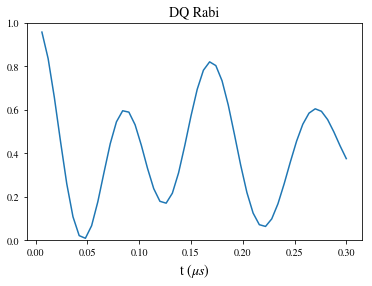

In [8]:
rabi_eps = rabi_sweep(max_t=0.3,n=50)
plt.plot(rabi_eps['t'], ham_model.likelihood(0, true_value[np.newaxis,:], rabi_eps)[0,0,:])
plt.title('DQ Rabi')
plt.xlabel('t $(\mu s)$')
plt.ylim(0,1)

(0, 1)

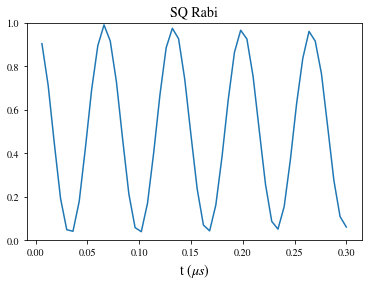

In [9]:
rabi_eps = rabi_sweep(max_t=0.3,n=50,wo=50)
params = true_value[np.newaxis,:]+np.array([5,-50,0,0,0])
plt.plot(rabi_eps['t'], ham_model.likelihood(0, params, rabi_eps)[0,0,:])
plt.title('SQ Rabi')
plt.xlabel('t $(\mu s)$')
plt.ylim([0,1])

(0, 1)

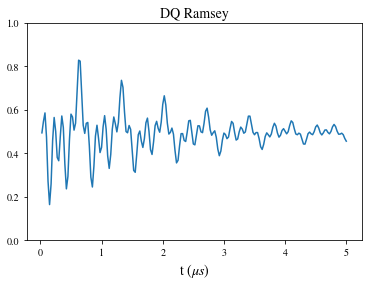

In [10]:
tp_est = 1 / true_value[0] / 4

ramsey_eps = ramsey_sweep(max_tau=5,n=200,tp=tp_est,phi=np.pi)
plt.plot(ramsey_eps['tau'], ham_model.likelihood(0, true_value[np.newaxis,:], ramsey_eps)[0,0,:])

plt.title('DQ Ramsey')
plt.xlabel('t $(\mu s)$')
plt.ylim([0,1])

### Speed Tests

In [11]:
%timeit -n1 -r1 ham_model.likelihood(1, wide_prior.sample(1000), rabi_sweep(max_t=0.3,n=50))
%timeit -n1 -r1 ham_model.likelihood(1, wide_prior.sample(1000), ramsey_sweep(max_tau=2,n=50))
if parallel:
    %timeit -n1 -r1 qi.DirectViewParallelizedModel(ham_model,dview).likelihood(1, wide_prior.sample(1000), rabi_sweep(max_t=0.3,n=50))
    %timeit -n1 -r1 qi.DirectViewParallelizedModel(ham_model,dview).likelihood(1, wide_prior.sample(1000), ramsey_sweep(max_tau=2,n=50))

1 loop, best of 1: 496 ms per loop
1 loop, best of 1: 890 ms per loop
1 loop, best of 1: 412 ms per loop
1 loop, best of 1: 463 ms per loop


In [12]:
updater = qi.SMCUpdater(ham_model, 5000, narrow_prior)
rabi_eps = rabi_sweep(max_t=0.3,n=50)
ramsey_eps = ramsey_sweep(max_tau=2,n=50)
%timeit -n1 -r1 updater.bayes_risk(rabi_eps)
%timeit -n1 -r1 updater.bayes_risk(ramsey_eps)
%timeit -n1 -r1 updater.expected_information_gain(rabi_eps)
%timeit -n1 -r1 updater.expected_information_gain(ramsey_eps)
if parallel:
    updater = qi.SMCUpdater(qi.DirectViewParallelizedModel(ham_model,dview), 5000, narrow_prior)
    %timeit -n1 -r1 updater.bayes_risk(rabi_eps)
    %timeit -n1 -r1 updater.bayes_risk(ramsey_eps)
    %timeit -n1 -r1 updater.expected_information_gain(rabi_eps)
    %timeit -n1 -r1 updater.expected_information_gain(ramsey_eps)

1 loop, best of 1: 2.07 s per loop
1 loop, best of 1: 4.02 s per loop
1 loop, best of 1: 2 s per loop
1 loop, best of 1: 3.99 s per loop
1 loop, best of 1: 1.9 s per loop
1 loop, best of 1: 2.06 s per loop
1 loop, best of 1: 1.89 s per loop
1 loop, best of 1: 2.01 s per loop


###  Test Risk and Information Gain

Overwriting ../fig/risk-and-ig-tight-prior.png
Overwriting ../fig/risk-and-ig-tight-prior.pdf


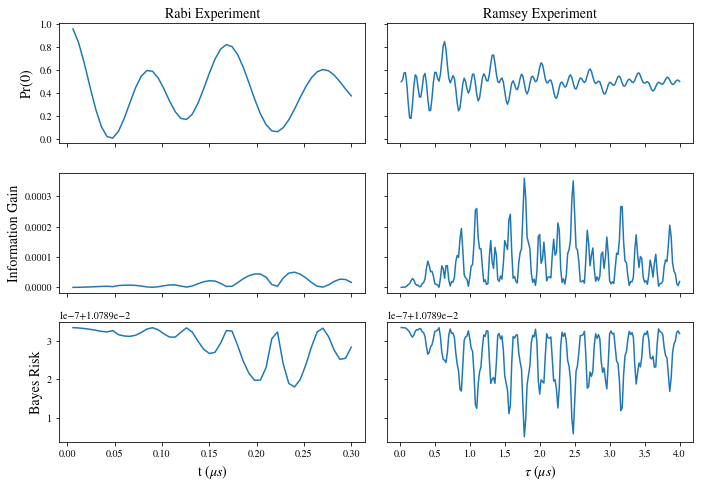

In [14]:
updater = qi.SMCUpdater(qi.DirectViewParallelizedModel(ham_model,dview), 5000, narrow_prior)
ham_model._Q = np.array([1,1,1,1,1])

fig = plt.figure(figsize=(10,7))

ax_rabi_sim = fig.add_subplot(3,2,1)
ax_rabi_ig = fig.add_subplot(3,2,3, sharex=ax_rabi_sim)
ax_rabi_risk = fig.add_subplot(3,2,5, sharex=ax_rabi_sim)

rabi_eps = rabi_sweep(max_t=0.3,n=50)
ax_rabi_sim.plot(rabi_eps['t'], ham_model.likelihood(0, true_value[np.newaxis,:], rabi_eps)[0,0,:], label='Rabi Simulation')
ax_rabi_ig.plot(rabi_eps['t'], updater.expected_information_gain(rabi_eps), label='Rabi EIG')
ax_rabi_risk.plot(rabi_eps['t'], np.sqrt(updater.bayes_risk(rabi_eps)), label='Rabi Bayes Risk')

ax_ramsey_sim = fig.add_subplot(3,2,2, sharey=ax_rabi_sim)
ax_ramsey_ig = fig.add_subplot(3,2,4, sharex=ax_ramsey_sim, sharey=ax_rabi_ig)
ax_ramsey_risk = fig.add_subplot(3,2,6, sharex=ax_ramsey_sim, sharey=ax_rabi_risk)

tp_est = 1 / true_value[0] / 4
ramsey_eps = ramsey_sweep(max_tau=4,n=200,tp=tp_est)
ax_ramsey_sim.plot(ramsey_eps['tau'], ham_model.likelihood(0, true_value[np.newaxis,:], ramsey_eps)[0,0,:], label='Ramsey Simulation')
ax_ramsey_ig.plot(ramsey_eps['tau'], updater.expected_information_gain(ramsey_eps), label='Ramsey EIG')
ax_ramsey_risk.plot(ramsey_eps['tau'], np.sqrt(updater.bayes_risk(ramsey_eps)), label='Ramsey Bayes Risk')

plt.setp(ax_ramsey_sim.get_xticklabels(), visible=False)
plt.setp(ax_ramsey_ig.get_xticklabels(), visible=False)
plt.setp(ax_rabi_sim.get_xticklabels(), visible=False)
plt.setp(ax_rabi_ig.get_xticklabels(), visible=False)
plt.setp(ax_ramsey_sim.get_yticklabels(), visible=False)
plt.setp(ax_ramsey_ig.get_yticklabels(), visible=False)
plt.setp(ax_ramsey_risk.get_yticklabels(), visible=False)
ax_rabi_risk.set_xlabel(r't $(\mu s)$')
ax_ramsey_risk.set_xlabel(r'$\tau$ $(\mu s)$')
ax_rabi_ig.set_ylabel('Information Gain')
ax_rabi_sim.set_ylabel(r'Pr$(0)$')
ax_rabi_risk.set_ylabel('Bayes Risk')
ax_rabi_sim.set_title('Rabi Experiment')
ax_ramsey_sim.set_title('Ramsey Experiment')
plt.tight_layout()

export_figure(fig, 'risk-and-ig-tight-prior')

Overwriting ../fig/risk-and-ig-compare-strategies.png
Overwriting ../fig/risk-and-ig-compare-strategies.pdf


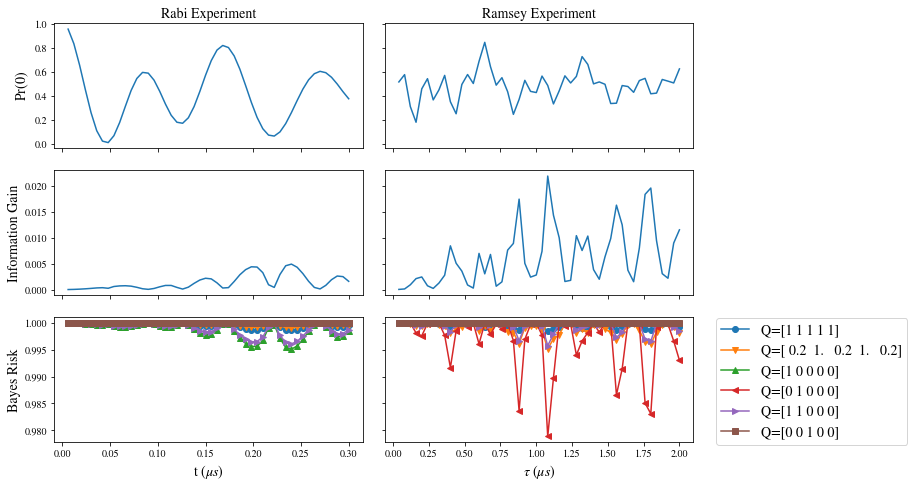

In [20]:
def weighted_variance(updater):
    xs = updater.particle_locations-updater.est_mean()
    xs = np.sum(updater.model.Q * xs**2, axis=1)
    return np.sum(updater.particle_weights * xs)

updater = qi.SMCUpdater(ham_model, 5000, medium_prior)
Qs = [
    np.array([1,1,1,1,1]),
    np.array([0.2,1,0.2,1,0.2]),
    np.array([1,0,0,0,0]),
    np.array([0,1,0,0,0]),
    np.array([1,1,0,0,0]),
    np.array([0,0,1,0,0]),
]

fig = plt.figure(figsize=(10,7))
markers = itertools.cycle(('o', 'v', '^', '<', '>', 's', '8', 'p'))

ax_rabi_sim = fig.add_subplot(3,2,1)
ax_rabi_ig = fig.add_subplot(3,2,3, sharex=ax_rabi_sim)
ax_rabi_risk = fig.add_subplot(3,2,5, sharex=ax_rabi_sim)

rabi_eps = rabi_sweep(max_t=0.3,n=50)
ax_rabi_sim.plot(rabi_eps['t'], ham_model.likelihood(0, true_value[np.newaxis,:], rabi_eps)[0,0,:], label='Rabi Simulation')
ax_rabi_ig.plot(rabi_eps['t'], updater.expected_information_gain(rabi_eps), label='Rabi EIG')

ax_ramsey_sim = fig.add_subplot(3,2,2, sharey=ax_rabi_sim)
ax_ramsey_ig = fig.add_subplot(3,2,4, sharex=ax_ramsey_sim, sharey=ax_rabi_ig)
ax_ramsey_risk = fig.add_subplot(3,2,6, sharex=ax_ramsey_sim, sharey=ax_rabi_risk)

tp_est = 1 / true_value[0] / 4
ramsey_eps = ramsey_sweep(max_tau=2,n=50,tp=tp_est)
ax_ramsey_sim.plot(ramsey_eps['tau'], ham_model.likelihood(0, true_value[np.newaxis,:], ramsey_eps)[0,0,:], label='Ramsey Simulation')
ax_ramsey_ig.plot(ramsey_eps['tau'], updater.expected_information_gain(ramsey_eps), label='Ramsey EIG')

for idx_Q, Q in enumerate(Qs):
    marker = markers.next()
    ham_model._Q = Q
    
    ax_rabi_risk.plot(rabi_eps['t'], np.sqrt(updater.bayes_risk(rabi_eps) / weighted_variance(updater)), marker=marker, label='Q={}'.format(Q))
    ax_ramsey_risk.plot(ramsey_eps['tau'], np.sqrt(updater.bayes_risk(ramsey_eps) / weighted_variance(updater)), marker=marker, label='Q={}'.format(Q))


plt.setp(ax_ramsey_sim.get_xticklabels(), visible=False)
plt.setp(ax_ramsey_ig.get_xticklabels(), visible=False)
plt.setp(ax_rabi_sim.get_xticklabels(), visible=False)
plt.setp(ax_rabi_ig.get_xticklabels(), visible=False)
plt.setp(ax_ramsey_sim.get_yticklabels(), visible=False)
plt.setp(ax_ramsey_ig.get_yticklabels(), visible=False)
plt.setp(ax_ramsey_risk.get_yticklabels(), visible=False)
ax_rabi_risk.set_xlabel(r't $(\mu s)$')
ax_ramsey_risk.set_xlabel(r'$\tau$ $(\mu s)$')
ax_rabi_ig.set_ylabel('Information Gain')
ax_rabi_sim.set_ylabel(r'Pr$(0)$')
ax_rabi_risk.set_ylabel('Bayes Risk')
ax_rabi_sim.set_title('Rabi Experiment')
ax_ramsey_sim.set_title('Ramsey Experiment')
plt.tight_layout()
plt.sca(ax_ramsey_risk)
plt.legend(bbox_to_anchor=(1.05, 1.05))

export_figure(fig, 'risk-and-ig-compare-strategies')

Overwriting ../fig/risk-bern-vs-bin.png
Overwriting ../fig/risk-bern-vs-bin.pdf


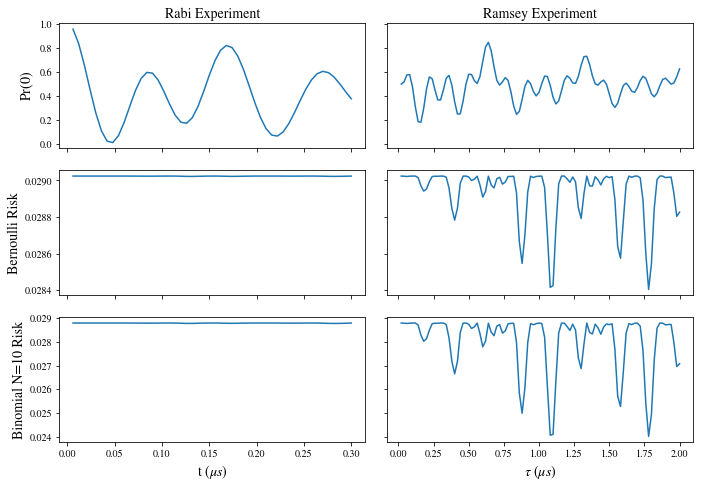

In [23]:
bern_model = m.RabiRamseyModel()
bin_model = qi.BinomialModel(bern_model)
updater_bern = qi.SMCUpdater(bern_model, 5000, medium_prior)
updater_bin = qi.SMCUpdater(bin_model, 5000, medium_prior)
bern_model._Q = np.array([0,1,0,0,0])
bin_model._Q = np.array([0,1,0,0,0])

fig = plt.figure(figsize=(10,7))

ax_rabi_sim = fig.add_subplot(3,2,1)
ax_rabi_bern = fig.add_subplot(3,2,3, sharex=ax_rabi_sim)
ax_rabi_bin = fig.add_subplot(3,2,5, sharex=ax_rabi_sim)

rabi_eps = rabi_sweep(max_t=0.3,n=50,n_bin=10)
ax_rabi_sim.plot(rabi_eps['t'], ham_model.likelihood(0, true_value[np.newaxis,:], rabi_eps)[0,0,:], label='Rabi Simulation')
ax_rabi_bern.plot(rabi_eps['t'], np.sqrt(updater_bern.bayes_risk(rabi_eps)))
ax_rabi_bin.plot(rabi_eps['t'], np.sqrt(updater_bin.bayes_risk(rabi_eps)))

ax_ramsey_sim = fig.add_subplot(3,2,2, sharey=ax_rabi_sim)
ax_ramsey_bern = fig.add_subplot(3,2,4, sharex=ax_ramsey_sim, sharey=ax_rabi_bern)
ax_ramsey_bin = fig.add_subplot(3,2,6, sharex=ax_ramsey_sim, sharey=ax_rabi_bin)

tp_est = 1 / true_value[0] / 4
ramsey_eps = ramsey_sweep(max_tau=2,n=100,tp=tp_est,n_bin=10)
ax_ramsey_sim.plot(ramsey_eps['tau'], ham_model.likelihood(0, true_value[np.newaxis,:], ramsey_eps)[0,0,:], label='Ramsey Simulation')
ax_ramsey_bern.plot(ramsey_eps['tau'], np.sqrt(updater_bern.bayes_risk(ramsey_eps)))
ax_ramsey_bin.plot(ramsey_eps['tau'], np.sqrt(updater_bin.bayes_risk(ramsey_eps)))

plt.setp(ax_ramsey_sim.get_xticklabels(), visible=False)
plt.setp(ax_ramsey_bern.get_xticklabels(), visible=False)
plt.setp(ax_rabi_sim.get_xticklabels(), visible=False)
plt.setp(ax_rabi_bern.get_xticklabels(), visible=False)
plt.setp(ax_ramsey_sim.get_yticklabels(), visible=False)
plt.setp(ax_ramsey_bern.get_yticklabels(), visible=False)
plt.setp(ax_ramsey_bin.get_yticklabels(), visible=False)
ax_rabi_bin.set_xlabel(r't $(\mu s)$')
ax_ramsey_bin.set_xlabel(r'$\tau$ $(\mu s)$')
ax_rabi_bern.set_ylabel('Bernoulli Risk')
ax_rabi_sim.set_ylabel(r'Pr$(0)$')
ax_rabi_bin.set_ylabel('Binomial N=10 Risk')
ax_rabi_sim.set_title('Rabi Experiment')
ax_ramsey_sim.set_title('Ramsey Experiment')
plt.tight_layout()

export_figure(fig, 'risk-bern-vs-bin')

### Heuristics

In [10]:
class RiskHeuristic(qi.Heuristic):
    def __init__(self, updater, Q, rabi_eps, ramsey_eps):
        self.updater = updater
        if not parallel:
            self._ham_model = m.RabiRamseyModel()
        else:
            self._ham_model = qi.DirectViewParallelizedModel(m.RabiRamseyModel(), dview, serial_threshold=1)
        self._ham_model._Q = Q
        self._risk_taker = qi.SMCUpdater(self._ham_model, updater.n_particles, wide_prior)
        self._update_risk_particles()
        self._rabi_eps = rabi_eps
        self._ramsey_eps = ramsey_eps
        self.name = "Bayes Risk, Q={}".format(Q)
        self.risk_history = []
        
    def _update_risk_particles(self):
        self._risk_taker.particle_locations = self.updater.particle_locations
        self._risk_taker.particle_weights = self.updater.particle_weights
        
    def __call__(self, tp):
        ramsey_eps = self._ramsey_eps
        ramsey_eps['t'] = tp
        all_eps = np.concatenate([self._rabi_eps, ramsey_eps])
        
        self._update_risk_particles()
        
        risk = self._risk_taker.bayes_risk(all_eps)
        self.risk_history += [risk]
        best_idx = np.argmin(risk, axis=0)
        eps = np.array([all_eps[best_idx]])
        return eps
    
class InfoGainHeuristic(qi.Heuristic):
    def __init__(self, updater, rabi_eps, ramsey_eps):
        self.updater = updater
        if not parallel:
            self._ham_model = m.RabiRamseyModel()
        else:
            self._ham_model = qi.DirectViewParallelizedModel(m.RabiRamseyModel(), dview, serial_threshold=1)
        self._risk_taker = qi.SMCUpdater(self._ham_model, updater.n_particles, wide_prior)
        self._update_risk_particles()
        self._rabi_eps = rabi_eps
        self._ramsey_eps = ramsey_eps
        self.name = "Expected Information Gain"
        self.risk_history = []
        
    def _update_risk_particles(self):
        self._risk_taker.particle_locations = self.updater.particle_locations
        self._risk_taker.particle_weights = self.updater.particle_weights
        
    def __call__(self, tp):
        ramsey_eps = self._ramsey_eps
        ramsey_eps['t'] = tp
        all_eps = np.concatenate([self._rabi_eps, ramsey_eps])
        
        self._update_risk_particles()
        
        eig = self._risk_taker.expected_information_gain(all_eps)
        self.risk_history += [eig]
        best_idx = np.argmax(eig, axis=0)
        eps = np.array([all_eps[best_idx]])
        return eps
    
class ExponentialHeuristic(qi.Heuristic):
    def __init__(self, updater, max_t=0.3, max_tau=2, base=11/10, n=50, n_bin=100):
        self.updater = updater
        self._rabi_eps = rabi_sweep(max_t=1, n=n, n_bin=n_bin)
        self._ramsey_eps = ramsey_sweep(max_tau=1, n=n, n_bin=n_bin)
        
        self._rabi_eps['t'] = max_t * (base ** np.arange(n)) / (base ** (n-1))
        self._ramsey_eps['tau'] = max_tau * (base ** np.arange(n)) / (base ** (n-1))
        
        self._rabi_eps['t'] = np.round(self._rabi_eps['t'] / 0.002) * 0.002
        self._ramsey_eps['tau'] = np.round(self._ramsey_eps['tau'] / 0.002) * 0.002
        
        self._idx = 0
        self.name = "Exponentially Sparse Heur"
        
    def __call__(self, tp):
        ramsey_eps = self._ramsey_eps
        ramsey_eps['t'] = tp
        all_eps = np.vstack([self._rabi_eps, ramsey_eps]).reshape((-1,), order='F')
        
        eps =  np.array([all_eps[self._idx]])
        self._idx += 1
        return eps
    
class LinearHeuristic(qi.Heuristic):
    def __init__(self, updater, max_t=0.3, max_tau=2, n=50, n_bin=100):
        self.updater = updater
        self._rabi_eps = rabi_sweep(max_t=1, n=n, n_bin=n_bin)
        self._ramsey_eps = ramsey_sweep(max_tau=1, n=n, n_bin=n_bin)
        
        self._rabi_eps['t'] = np.round(self._rabi_eps['t'] / 0.002) * 0.002
        self._ramsey_eps['tau'] = np.round(self._ramsey_eps['tau'] / 0.002) * 0.002
        
        self._idx = 0
        self.name = "Standard Linear Heuristic"
        
    def __call__(self, tp):
        ramsey_eps = self._ramsey_eps
        ramsey_eps['t'] = tp
        all_eps = np.vstack([self._rabi_eps, ramsey_eps]).reshape((-1,), order='F')
        
        eps =  np.array([all_eps[self._idx]])
        self._idx += 1
        return eps

### Adaptive Simulations

In [ ]:
n_bin = 10
n_particles = 10000
n_trials = 100

def make_updater():
    if not parallel:
        return qi.BinomialModel(m.RabiRamseyModel())
    else:
        return qi.DirectViewParallelizedModel(qi.BinomialModel(m.RabiRamseyModel()), dview, serial_threshold=1)

Qs = [
    np.array([1,1,1,1,1]),
    np.array([1,0,0,0,0]),
    np.array([0,1,0,0,0]),
    np.array([1,1,0,0,0]),
    np.array([0,0,1,0,0])
]
heuristics = [
    RiskHeuristic(
        qi.SMCUpdater(make_updater(), n_particles, wide_prior), 
        Q, 
        rabi_sweep(max_t=0.5, n=50, n_bin=n_bin), 
        ramsey_sweep(max_tau=2, n=50, n_bin=n_bin)
    )
    for Q in Qs
]

heuristics += [InfoGainHeuristic(
    qi.SMCUpdater(make_updater(), n_particles, wide_prior), 
    rabi_sweep(max_t=0.5, n=50, n_bin=n_bin), 
    ramsey_sweep(max_tau=2, n=50, n_bin=n_bin)
)]
heuristics += [ExponentialHeuristic(
    qi.SMCUpdater(make_updater(), n_particles, wide_prior),
    max_t=0.5, max_tau=2, base=11/10, n=50, n_bin=n_bin
)]
heuristics += [LinearHeuristic(
    qi.SMCUpdater(make_updater(), n_particles, wide_prior),
    max_t=0.5, max_tau=2, n=50, n_bin=n_bin
)]

n_updaters = len(heuristics)

track_means = np.zeros((n_updaters, n_trials + 1, 5))
track_covs = np.zeros((n_updaters, n_trials + 1, 5, 5))
for idx, h in enumerate(heuristics):
    track_means[idx, 0, :] = h.updater.est_mean()
    track_covs[idx, 0, :, :] = h.updater.est_covariance_mtx()


for idx_eps in range(n_trials):
    
    for idx in range(n_updaters):
        heuristic = heuristics[idx]
        updater = heuristic.updater
    
        #estimate ramsey pulse time
        current_est = updater.est_mean()
        tp_est = np.round(1 / current_est[0] / 4 / 0.002) * 0.002

        #decide experiment
        eps = heuristic(tp_est)
        print("{}: {} : {}".format(idx_eps, heuristic.name, eps[0])), np.round(1000 * np.sqrt(np.diag(updater.est_covariance_mtx())))

        # simulate outcome
        outcome = updater.model.simulate_experiment(true_value[np.newaxis,:], eps)

        # update
        updater.update(outcome, eps)
        
        # store info
        track_means[idx, idx_eps + 1, :] = updater.est_mean()
        track_covs[idx, idx_eps, :, :] = updater.est_covariance_mtx()
    print "---"

0: Bayes Risk, Q=[1 1 1 1 1] : ( 0.03,  0.,  0.,  0., 0, 10) [ 2892.  2904.  2894.   581.   287.]
0: Bayes Risk, Q=[1 0 0 0 0] : ( 0.03,  0.,  0.,  0., 0, 10) [ 2905.  2905.  2899.   574.   285.]
0: Bayes Risk, Q=[0 1 0 0 0] : ( 0.03,  0.,  0.,  0., 0, 10) [ 2903.  2865.  2893.   579.   287.]
0: Bayes Risk, Q=[1 1 0 0 0] : ( 0.03,  0.,  0.,  0., 0, 10) [ 2871.  2874.  2873.   576.   286.]
0: Bayes Risk, Q=[0 0 1 0 0] : ( 0.03,  0.,  0.,  0., 0, 10) [ 2888.  2855.  2880.   575.   285.]
0: Expected Information Gain : ( 0.03,  0.,  0.,  0., 0, 10) [ 2892.  2902.  2915.   579.   287.]
0: Exponentially Sparse Heur : ( 0.004,  0.,  0.,  0., 0, 10) [ 2877.  2889.  2883.   574.   283.]
0: Standard Linear Heuristic : ( 0.02,  0.,  0.,  0., 0, 10) [ 2903.  2900.  2902.   582.   286.]
---


/home/ihincks/.local/share/miniconda2/envs/nvmeas/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


Overwriting ../fig/qhl-wr-variance.png
Overwriting ../fig/qhl-wr-variance.pdf


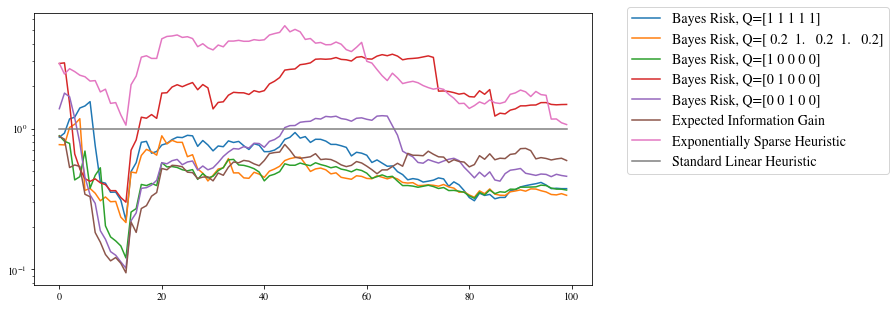

In [56]:
fig=plt.figure(figsize=(10,5))
for idx_h, h in enumerate(heuristics):
    plt.semilogy(np.sqrt(track_covs[idx_h,:,0,0]/track_covs[-1,:,0,0]), label=h.name)
plt.legend(bbox_to_anchor=(1.05, 1.05))
export_figure(fig, 'qhl-wr-variance')

/home/ihincks/.local/share/miniconda2/envs/nvmeas/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


Overwriting ../fig/qhl-wr-variance.png
Overwriting ../fig/qhl-wr-variance.pdf


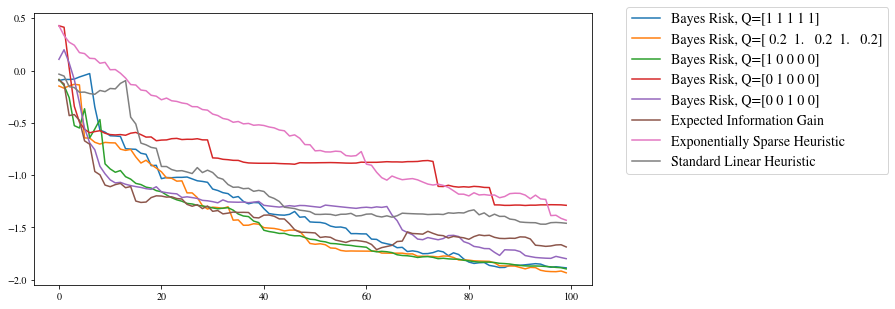

In [57]:
fig=plt.figure(figsize=(10,5))
for idx_h, h in enumerate(heuristics):
    plt.plot(np.log10(np.sqrt(track_covs[idx_h,:,0,0])), label=h.name)
plt.legend(bbox_to_anchor=(1.05, 1.05))
export_figure(fig, 'qhl-wr-variance')

/home/ihincks/.local/share/miniconda2/envs/nvmeas/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


Overwriting ../fig/qhl-we-variance.png
Overwriting ../fig/qhl-we-variance.pdf


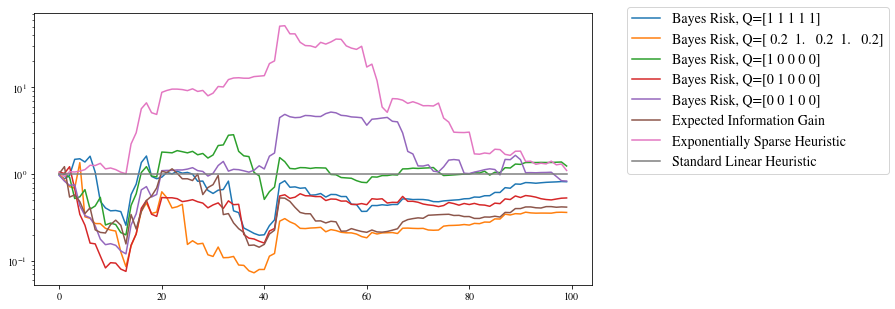

In [58]:
fig=plt.figure(figsize=(10,5))
for idx_h, h in enumerate(heuristics):
    plt.semilogy(np.sqrt(track_covs[idx_h,:,1,1]/track_covs[-1,:,1,1]), label=h.name)
plt.legend(bbox_to_anchor=(1.05, 1.05))
export_figure(fig, 'qhl-we-variance')

/home/ihincks/.local/share/miniconda2/envs/nvmeas/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


Overwriting ../fig/qhl-we-variance.png
Overwriting ../fig/qhl-we-variance.pdf


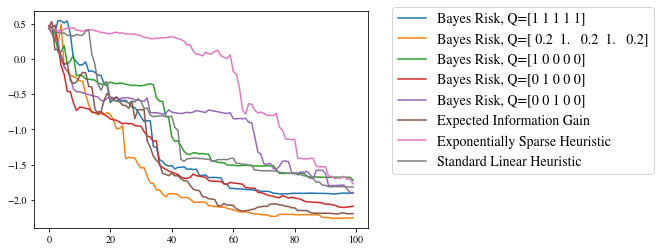

In [55]:
fig=plt.figure()
for idx_h, h in enumerate(heuristics):
    plt.plot(np.log10(np.sqrt(track_covs[idx_h,:,1,1])), label=h.name)
plt.legend(bbox_to_anchor=(1.05, 1.05))
export_figure(fig, 'qhl-we-variance')

/home/ihincks/.local/share/miniconda2/envs/nvmeas/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


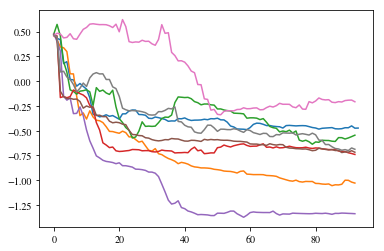

In [37]:
plt.plot(np.log10(np.sqrt(track_covs[:,:,2,2])).T)